In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
sub = xr.open_dataset('../data/netcdfs/banner_lowman_05208_21019-019_21021-007_0006d.nc')

In [3]:
for name, values in sub.items():
    if name != 'dem':
        sub[name] = sub[name].where(sub['dem'] != -10000.0)
sub['dem'] = sub['dem'].where(sub['dem'] != -10000.0)

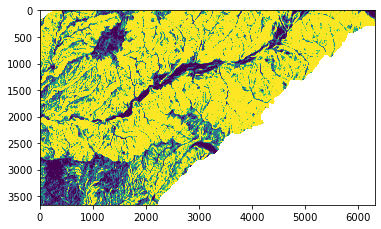

In [5]:
plt.imshow(sub['focal_var'], vmin = 0.8, vmax = 10)

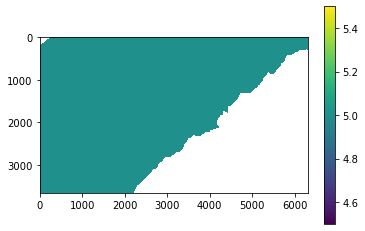

In [43]:
col = 'lithography'

da = sub[col]
vmin_val = np.nanmean(da) - np.nanstd(da)
vmax_val = np.nanmean(da) + np.nanstd(da)
plt.imshow(da, vmin = vmin_val, vmax = vmax_val)
plt.colorbar()

In [158]:
sub

<xarray.Dataset>
Dimensions:           (x: 3661, y: 6306)
Dimensions without coordinates: x, y
Data variables: (12/37)
    VV-int-imaginary  (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    inc               (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    HV-int-real       (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    HH-int-imaginary  (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    HH-amp2           (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    HH-amp1           (x, y) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...                ...
    lithography       (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    focal_var         (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    ppt_total         (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmean             (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    mean_af_days      (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_af_days       (x, y) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/235)
    uavsar rpi annotation file version number:       2.3 -
    site description:                                Lowman, CO
    flight plan comments of pass 1:                  nan
    flight plan comments of pass 2:                  nan
    processing comments:                             nan
    url:                                             http://uavsar.jpl.nasa.g...
    ...                                              ...
    slt_phs.dsp_cmap:                                cmy
    grd_phs.dsp_cmap:                                cmy
    slc_phs.dsp_cmap:                                cmy
    set_hddr:                                        0 bytes
    set_tail:                                        0 bytes
    subset_coords:                                   [-115.6    44.   -115.2 ...

In [6]:
y = sub['VV-cor'][100:3000,100:2700].values.ravel()
y = y[~np.isnan(y)]

ls = ['trees','slope','dem','focal_var','tmean','inc','ppt_total','focal_var','land_forms']
data = pd.DataFrame()
for var in ls:
    x = sub[var][100:3000,100:2700].values.ravel()
    x = x[~np.isnan(y)]

    data[var] = x

x = sub['aspect'][100:3000,100:2700].values.ravel()
x = x[~np.isnan(y)]

data['easting'] = np.cos(x)
data['northing'] = np.sin(x)

data['target'] = y

## Build Pipelines

In [7]:
numeric_features = data.columns.drop(['land_forms','target'])
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

categorical_features = ["land_forms"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])

In [8]:
y = data.target
X = data.drop(['target'],axis = 1)


lr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('classify', Ridge(fit_intercept=False))
])

lr_pipe.fit(X,y)

preds = lr_pipe.predict(X)

print('R2')
print(r2_score(y, preds))
for i in range(len(X.columns)):
    print(X.columns[i])
    print(lr_pipe.named_steps['classify'].coef_[i])

R2
0.08830879673551983
trees
-0.01271516854730042
slope
0.0037236152411101843
dem
-0.027468202545567505
focal_var
-0.004286686233172466
tmean
0.10632737444318212
inc
-0.0009702415662967874
ppt_total
0.10938674828044377
land_forms
-0.005580284154950184
easting
0.021029813986056606
northing
0.3998405486687878


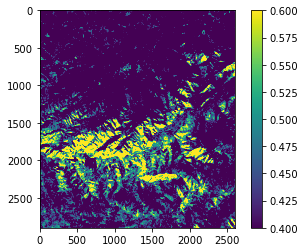

In [11]:
plt.imshow(data['target'].values.reshape((2900,2600)),vmax = 0.6,vmin = 0.4)
plt.colorbar()

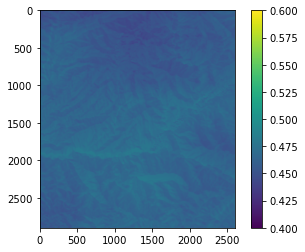

In [12]:
pred = lr_pipe.predict(X).reshape((2900,2600))
transformer_y = StandardScaler().fit(y.values.reshape(-1,1)) 
pred = transformer_y.inverse_transform(pred)

plt.imshow(pred,vmax = 0.6,vmin = 0.4)
plt.colorbar()
plt.show()

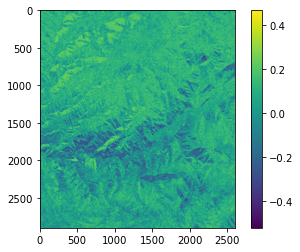

In [13]:
plt.imshow(pred-data['target'].values.reshape(2900,2600))
plt.colorbar()

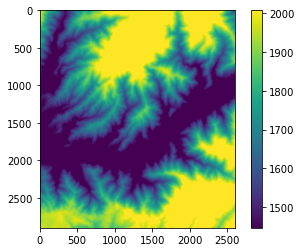

In [22]:
col = 'dem'

da = sub[col][100:3000,100:2700]

vmin_val = np.nanmean(da) - np.nanstd(da)
vmax_val = np.nanmean(da) + np.nanstd(da)
plt.imshow(da, vmin = vmin_val, vmax = vmax_val)
plt.colorbar()

In [ ]:
from sklearn.linear_model import ElasticNet
y = data.target
X = data.drop(['target'],axis = 1)


br_pipe = Pipeline([
    ('preproc', preprocessor),
    ('classify', ElasticNet(alpha = 0.001, fit_intercept = False))
])

br_pipe.fit(X,y)

preds = br_pipe.predict(X)

print('R2')
print(r2_score(y, preds))
for i in range(len(X.columns)):
    print(X.columns[i])
    print(br_pipe.named_steps['classify'].coef_[i])

In [18]:
c = data.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

print(so[:110])

target     slope        0.000656
slope      target       0.000656
dem        easting      0.004279
easting    dem          0.004279
focal_var  target       0.007437
                          ...   
tmean      dem          0.776190
focal_var  slope        0.889378
slope      focal_var    0.889378
tmean      ppt_total    0.960629
ppt_total  tmean        0.960629
Length: 110, dtype: float64


In [19]:
data.corr()

,trees,slope,dem,focal_var,tmean,inc,ppt_total,land_forms,easting,northing,target
trees,1.000000,-0.037853,-0.058174,-0.031501,-0.037091,0.160198,0.052435,0.053047,0.011881,-0.140151,-0.065981
slope,-0.037853,1.000000,-0.096047,0.889378,0.016610,0.069332,-0.021526,0.045543,0.008689,-0.129535,-0.000656
dem,-0.058174,-0.096047,1.000000,-0.101873,-0.776190,-0.111515,0.743060,-0.330205,0.004279,0.027889,-0.176179
focal_var,-0.031501,0.889378,-0.101873,1.000000,0.016683,0.052138,-0.025381,0.053067,0.025814,-0.114522,-0.007437
tmean,-0.037091,0.016610,-0.776190,0.016683,1.000000,0.086125,-0.960629,0.139556,-0.028625,0.032807,0.152839
inc,0.160198,0.069332,-0.111515,0.052138,0.086125,1.000000,-0.108353,-0.175051,-0.411303,-0.331926,-0.038703
ppt_total,0.052435,-0.021526,0.743060,-0.025381,-0.960629,-0.108353,1.000000,-0.144046,0.012687,-0.084936,-0.098309
land_forms,0.053047,0.045543,-0.330205,0.053067,0.139556,-0.175051,-0.144046,1.000000,0.277419,0.131164,0.053780
easting,0.011881,0.008689,0.004279,0.025814,-0.028625,-0.411303,0.012687,0.277419,1.000000,0.091139,-0.034486
northing,-0.140151,-0.129535,0.027889,-0.114522,0.032807,-0.331926,-0.084936,0.131164,0.091139,1.000000,0.094287
